In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import scipy.stats as stats
from IPython import display
display.set_matplotlib_formats('retina')

/tmp/ipython-input-7-2751838591.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('retina')


In [8]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [9]:
cols2zscore = cols2zscore.drop('residual sugar')
dataT = torch.tensor( data[cols2zscore].values).float()
sugar = torch.tensor( data['residual sugar'].values).float()
sugar = sugar[:,None]

Text(0, 0.5, 'Sugar(norm.)')

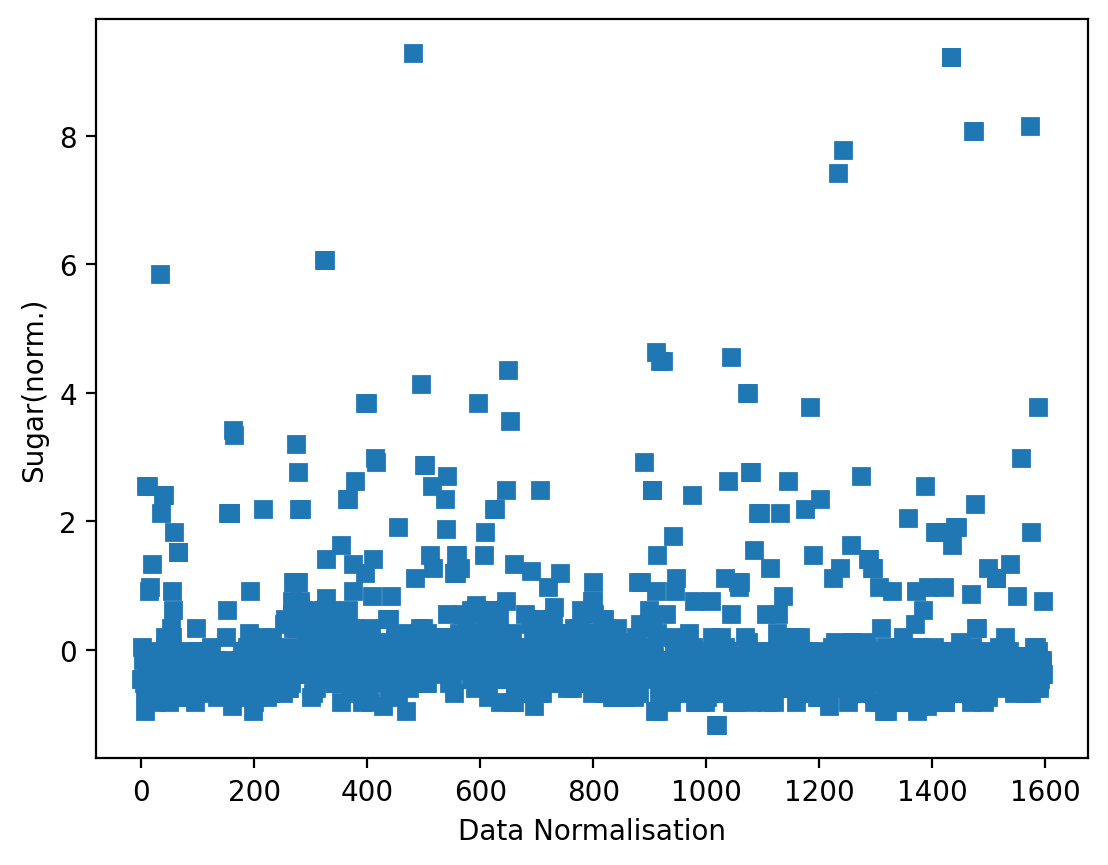

In [10]:
plt.plot(sugar,'s')
plt.xlabel('Data Normalisation')
plt.ylabel('Sugar(norm.)')

In [11]:
train_dataSK,test_dataSK, train_labelsSK,test_labelsSK = train_test_split(dataT,sugar,test_size=.1)
train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset = torch.utils.data.TensorDataset(test_dataSK,test_labelsSK)
batchsize = 32
train_loader = DataLoader(train_dataDataset,batch_size= batchsize, shuffle = True,drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size= test_dataDataset.tensors[0].shape[0])

In [19]:
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()
    self.input = nn.Linear(11,16)
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)
    self.output = nn.Linear(32,1)
  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.output(x)


In [20]:
numepochs = 1000
def trainTheModel():
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  for epochi in range(numepochs):
    winenet.train()
    batchLoss = [0]
    for X,y in train_loader:
      yHat = winenet(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
    trainLoss[epochi] = np.mean(batchLoss)
    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
      testLoss[epochi] = lossfun(yHat,y).item()
  return trainLoss,testLoss

In [21]:
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()

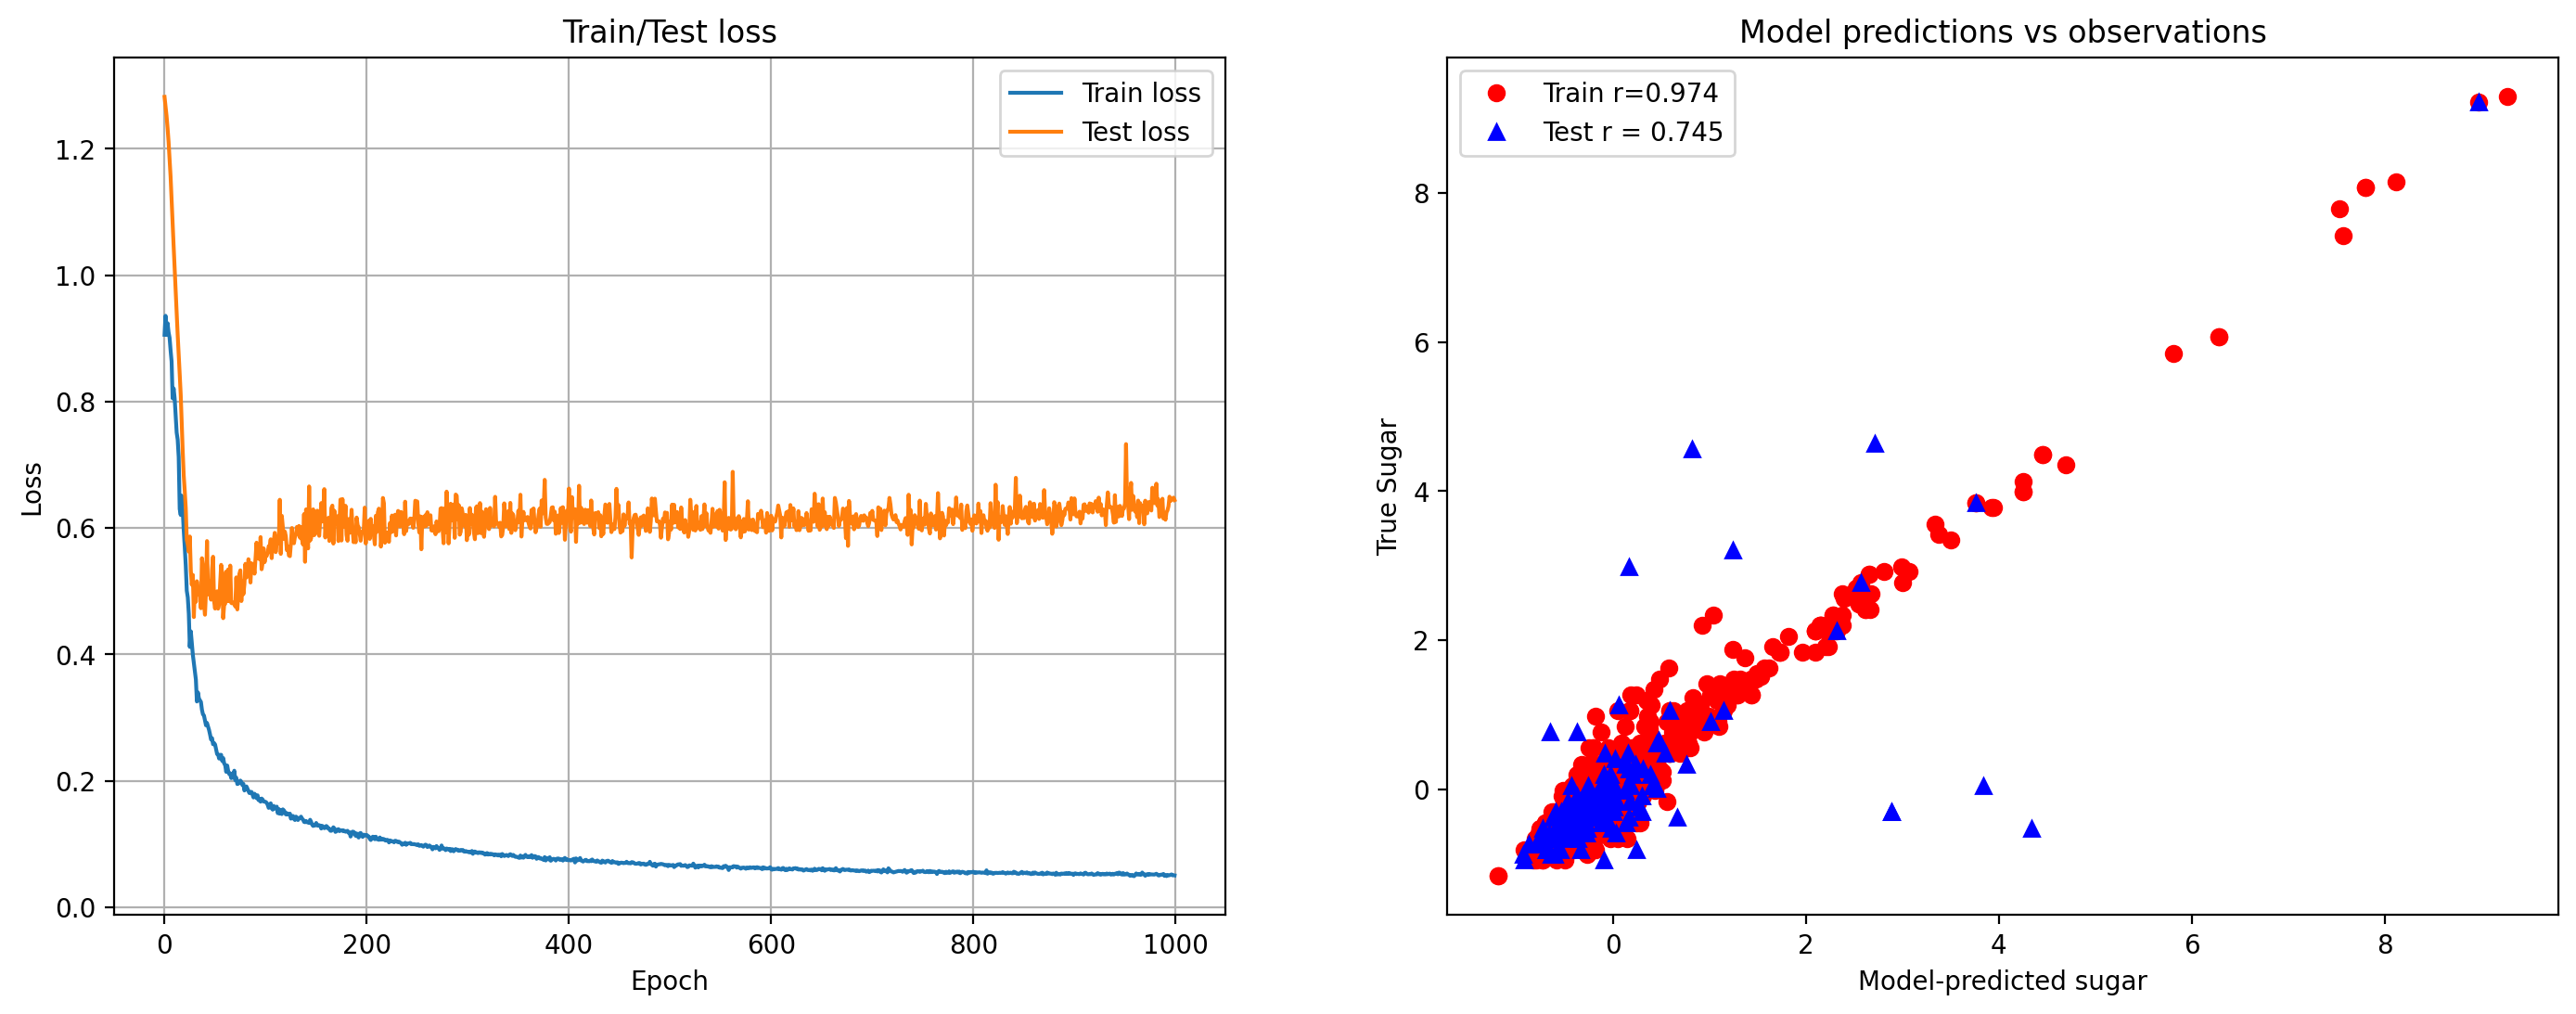

In [24]:
fig,ax = plt.subplots(1,2,figsize=(17,6))
ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

yHatTrain = winenet(train_dataSK)
yHatTest = winenet(test_dataSK)
ax[1].plot(yHatTrain.detach(),train_labelsSK,'ro')
ax[1].plot(yHatTest.detach(),test_labelsSK,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True Sugar')
ax[1].set_title('Model predictions vs observations')
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsSK.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T,test_labelsSK.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}',f'Test r = {corrTest:.3f}'])


Text(0.5, 1.0, 'Data correlation matrix')

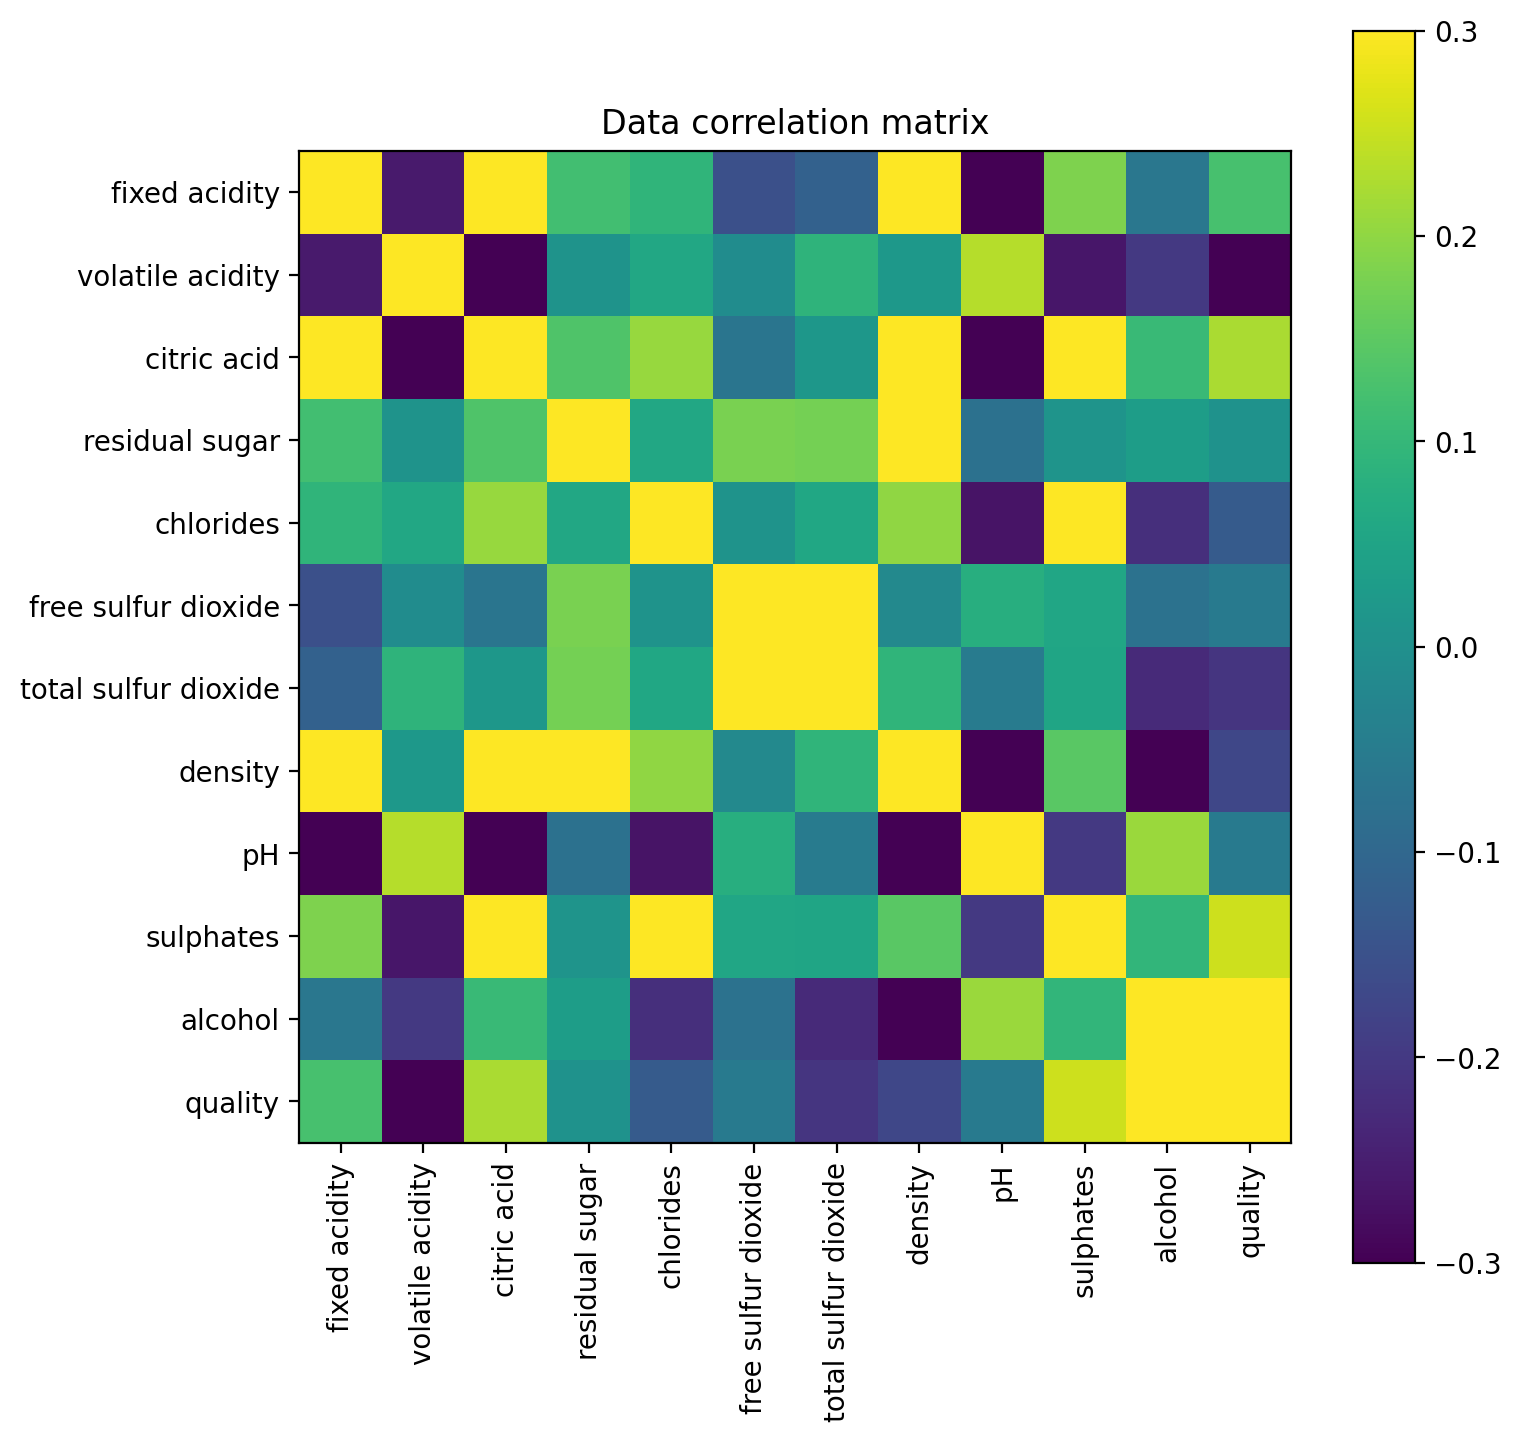

In [26]:
fig = plt.figure(figsize=(8,8))
plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')